# Quantum Teleportation Protocol

*Quantum Teleportation* is a protocol which makes use of ***quantum entanglement*** between two quantum systems and demonstrates how *quantum communication* can be achieved without some state being transmitted in the usual sense. *Classical communication* is also crucial in this protocol, therefore, this quantum information-based communication is part of the so-called *local operation - classical communication (LOCC)* category, where each party performs local quantum mechanical operations on their respective state and uses classical communication in order to communicate measurement results.

<img src="./images/entangle_1.jpg" width="60%" align="center">

In this protocol, quantum information is received by physically sending classical information. Let us assume we have two parties, commonly seen in bibliography as Alice and Bob, the transmitter and the receiver respectively.

First, let us import all necessary objects and methods for quantum circuits using ***qiskit*** library.

In [1]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, execute, Aer

Next, we import some basic modules whose utility is easily perceived throughout the code.

In [2]:
from math import pi, cos, sin
from random import randrange
import numpy as np

Create a quantum circuit with three qubits and two classical bits. Recall that qiskit uses reverse ordering, so we consider the least significant bit (LSB) to be q[0].

In [3]:
q =  QuantumRegister(3, "q")  # tag the qubits as q2, q1, q0
c1 = ClassicalRegister(1, "c1") # tag the classical bits as c1,c2
c2 = ClassicalRegister(1, "c2")
qc = QuantumCircuit(q, c1, c2)

The first qubit (q[2]) is the *message*, so we have an arbitrary state of the form

$$ \left | \psi \right > = a \left |0 \right > + b \left |1 \right > $$

where $ \left |a \right |^2 + \left | b \right |^2 = 1 $, with $ a,b \in \mathbb{C} $ and the *computational basis vectors*

$$ \left |0 \right > = \begin{pmatrix} 1 \\ 0 \end{pmatrix}, \ \ \left |1 \right > = \begin{pmatrix} 0 \\ 1 \end{pmatrix} $$

In *Python*, we can create a *normalized* state of this form by rotating the qubit by some random angle by using the  *RYGate* from *qiskit* with the following custom function, whose inputs consist of a qubit and a quantum circuit:

In [4]:
def random_qubit_state(q, qc):
    r = randrange(100)
    theta = 2*pi*(r/100)  # radians
    print("The picked angle is",r*3.6,"degrees and",theta,"radians")
    a = cos(theta)
    b = sin(theta)
    print("so, the message qubit has amplitudes a =",round(a, 4),"and b =",round(b, 4))
    qc.ry(2*theta, q)

More information on RYGate can be found on the qiskit documentation https://qiskit.org/documentation/stubs/qiskit.circuit.library.RYGate.html

### Entanglement: Some Information on Circuit Implementation

The first step in the protocol involves **entanglement sharing** between Alice's qubit (q[1]) and Bob's qubit (q[0]), assuming top-bottom ordering. This is performed by the *Bell circuit*, i.e a *unitary operator* $U_{Bell}$ constructed by a *Hadamard* $(H)$ and a *controlled-NOT* $(U_{CNOT})$ gate as

$$ U_{Bell} = U_{CNOT}(H \otimes I) $$

where $ I $ indicates the *identity operator*. It is easy to see that the action of $U_{Bell}$ in the *4-dimensional* computational basis $ \{ \left |00 \right >, \left |01 \right >, \left |10 \right >, \left |11 \right > \}$ results in the *Bell states*

$$ \left |\Phi ^{\pm} \right > = \frac{\left |00 \right > \pm \left |11 \right >}{\sqrt{2}}, \ \left |\Psi ^{\pm} \right > = \frac{\left |01 \right > \pm \left |10 \right >}{\sqrt{2}} $$

where the tensor product $ \left |0 \right > \otimes \left |0 \right > $ is denoted by $ \left |00 \right > $ and so on, for simplicity.

For the sake of brevity, we assume that Alice's and Bob's qubits are in the definite state $ \left |0 \right > $, so we start with the composite system $ \left |00 \right > $ and by applying $U_{Bell}$ we get

$$ U_{Bell} \left |00 \right > = \left |\Phi ^{+} \right > = \frac{\left |00 \right > + \left |11 \right >}{\sqrt{2}} $$

and the respective quantum circuit for entanglement is

<img src="./images/bell_00.png" width="30%" align="center">

The same circuit may be used by starting in one of the other states $ \left |01 \right >, \left |10 \right > $ or $ \left |11 \right > $ and the result will be some Bell state as seen from above.

### Teleportation: Step 1 (Entanglement Sharing)

Using the information above, the composite system at hand is

$$  \left | \psi \right > \otimes \left | 0_A0_B \right > = \left ( a \left |0 \right > + b \left |1 \right > \right ) \otimes \left | 0_A0_B \right > $$

and the entangled pair of particles is created by

$$ (I \otimes U_{Bell}) \left ( \left | \psi \right > \otimes \left | 0_A0_B \right > \right )= \left ( a \left |0 \right > + b \left |1 \right > \right ) \otimes \left ( \frac{\left |0_A0_B \right > + \left |1_A1_B \right >}{\sqrt{2}} \right ) = \frac{a \left( \left |00_A0_B \right > + \left |01_A1_B \right > \right ) + b \left( \left |10_A0_B \right > + \left |11_A1_B \right > \right)}{\sqrt{2}} $$

where indexes *A,B* indicate Alice's and Bob's qubits respectively.

To create the entangled pair between Alice and Bob, we use the following function with two qubits (*a*, *b*) and a quantum circuit (*qc*) as inputs:

In [5]:
def entangle(a, b, qc):
    qc.h(a)
    qc.cx(a, b)

### Teleportation: Step 2 (Transmitter Applies a CNOT Gate)

Now, assume that Alice and Bob are spatially separated by a long distance. Alice applies a CNOT gate, with **control qubit the message and target her own qubit**. Then, we have

$$ (U_{CNOT} \otimes I) \left ( \frac{a \left( \left |00_A0_B \right > + \left |01_A1_B \right > \right ) + b \left( \left |10_A0_B \right > + \left |11_A1_B \right > \right)}{\sqrt{2}} \right ) $$

resulting in

$$ \frac{a (\left |00_A0_B \right > + \left |01_A1_B \right >) + b(\left |11_A0_B \right > + \left |10_A1_B \right >)}{\sqrt{2}} $$

### Teleportation: Step 3 (Transmitter Applies a Hadamard Gate)

Next, Alice applies a Hadamard gate **on the message qubit** and the last expression becomes

$$ a \left ( \frac{\left | 0 \right > + \left | 1 \right >}{\sqrt{2}} \right ) \otimes \frac{(\left |0_A 0_B \right > +  \left | 1_A 1_B \right >)}{\sqrt{2}} + b \left ( \frac{\left | 0 \right > - \left | 1 \right >}{\sqrt{2}} \right )\otimes \frac{(\left |1_A 0_B \right > +  \left | 0_A 1_B \right >)}{\sqrt{2}} $$

resulting in

$$ \frac{1}{2} \left \{ a \left ( \left |00_A0_B \right > + \left |10_A0_B \right > + \left |01_A1_B \right > + \left |11_A1_B \right > \right ) + b \left ( \left |01_A0_B \right > - \left |11_A0_B \right > + \left |00_A1_B \right > - \left |10_A1_B \right > \right )  \right \} $$

The above steps involve action by the transmitter (Alice) and this is done by the next function, whose inputs consist of the message qubit (*mes*), Alice's entangled qubit (*q*) and the quantum circuit (*qc*):

In [6]:
def transmitter(mes, q, qc):
    qc.cx(mes, q)
    qc.h(mes)

If we isolate Bob's qubit, we have

$$ \frac{1}{2} \left | 00_A \right > \left ( a \left |0_B \right > + b \left |1_B \right > \right ) + \frac{1}{2} \left | 01_A \right > \left ( a \left |1_B \right > + b \left |0_B \right > \right ) + \frac{1}{2} \left | 10_A \right > \left ( a \left |0_B \right > - b \left |1_B \right > \right ) + \frac{1}{2} \left | 11_A \right > \left ( a \left |1_B \right > - b \left |0_B \right > \right ) $$

### Teleportation: Step 4 (Transmitter Measurement and Classical Communication)

The next step for Alice is to **measure** her pair of qubits in the basis $ \{ \left |00 \right >, \left |01 \right >, \left |10 \right >, \left |11 \right > \}$. It is clear that if Bob knows the measurement result, he can easily reconstruct the message through his qubit. The way this is done is by communicating with Alice through a **classical communication channel**.

The following function represents the measurements on Alice's qubits. For this purpose, we will need the message, the entangled qubit, the quantum circuit, as well as the classical registers to store the measurement results:

In [7]:
def measurement(mes, q, qc, c1, c2):
    qc.measure(mes, c1)
    qc.measure(q, c2)

### Teleportation: Step 5 (Receiver Action)

At last, when Bob knows the measurement result from Alice, he can simply act with some qubit gates and read the message. See that, if Alice measures $ \left | 00 \right > $, then Bob has nothing to do with his qubit as it is found in the state $ a \left |0 \right > + b \left |1 \right > $, which is the initial message. 

If Alice measures $ \left | 01 \right > $, then Bob's state is $ a \left |1_B \right > + b \left |0_B \right > $ and he only has to act with the Pauli X gate, known as NOT-gate, and reconstruct the initial message as $ X (a \left |1_B \right > + b \left |0_B \right >) = a \left |0 \right > + b \left |1 \right > $. 

If Alice measures $ \left | 10 \right > $, then Bob's state is $ a \left |0_B \right > - b \left |1_B \right > $ and he has to act with the Pauli Z gate and reconstruct the initial message as $ Z (a \left |0_B \right > - b \left |1_B \right >) = a \left |0 \right > + b \left |1 \right > $. 

The last measurement result from Alice is $ \left | 11 \right > $, so Bob's state would be $ a \left |1_B \right > - b \left |0_B \right > $ and in order to reconstruct the initial message, he has to act with the X gate first and the Z gate after, which can be represented by a matrix product as ZX.

This can be easily implemented with the following function, where we need the quantum circuit, Bob's qubit and the classical registers to read Alice's measurements:

In [8]:
def receiver(qc, q, c1, c2):
    qc.x(q).c_if(c1, 1)
    qc.z(q).c_if(c2, 1)

The following code utilizes the above functions to demonstrate the protocol. The *barrier()* method is used in order to separate the steps involved in the protocol.

In [9]:
# create a random message
random_qubit_state(q[2], qc)
qc.barrier()

# entangle Alice's and Bob's qubits
entangle(q[1], q[0], qc)
qc.barrier()

# Alice's action
transmitter(q[2], q[1], qc)
qc.barrier()
measurement(q[2], q[1], qc, c2, c1)

# Bob's action
qc.barrier()
receiver(qc, q[0], c1, c2)

The picked angle is 158.4 degrees and 2.764601535159018 radians
so, the message qubit has amplitudes a = -0.9298 and b = 0.3681


Before printing the circuit, we read the output state vector using 'statevector_simulator', as well as the classical outcome sent by Alice in order to verify the results:

In [10]:
job = execute(qc, Aer.get_backend('statevector_simulator'), optimization_level=0, shots=1)
current_quantum_state = job.result().get_statevector()
print()
print("The state vector is")
print()
for i in range(len(np.asarray(current_quantum_state))):
    print(round(current_quantum_state[i].real, 4))
    
print()

classical_outcomes = ['00','01','10','11']

for i in range(4):
    if (current_quantum_state[2*i].real != 0) or (current_quantum_state[2*i+1].real != 0):
        print(f"The classical outcome is '{classical_outcomes[i]}'")


The state vector is

0.0
0.0
-0.0
-0.0
-0.0
0.0
-0.9298
0.3681

The classical outcome is '11'


We clearly see that the amplitudes of the message qubit correspond to the right position of the output state vector, as indicated by the classical output above.

Let us now print the circuit:

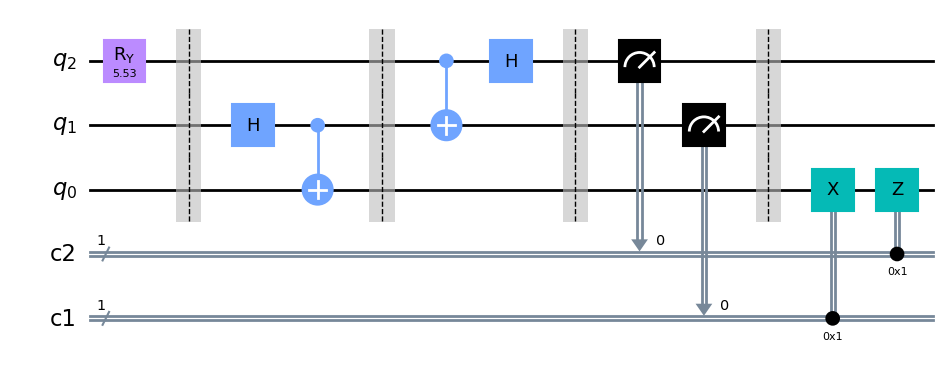

In [11]:
display(qc.draw(output='mpl', reverse_bits=True))

## Brief Summary

 - The protocol uses *three qubits* and *two* classical bits.
 - With *entanglement*, quantum information is received without sending a quantum system in the usual sense.
 - Without classical communication, Bob would just end up with a totally random state.
 - Nothing about the qubit message is communicated over the classical channel, thus security is maintained.
 - Quantum information is received by physically sending classical information.